# Initialize

In [1]:
import cv2 as cv
import albumentations as A
import os
import sys
import datetime
import io

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import (
    Conv2D,
    MaxPool2D,
    Dense,
    Flatten,
    Input,
    BatchNormalization,
    Layer,
    InputLayer,
    Dropout,
    Resizing,
    Rescaling,
    RandomFlip,
    RandomRotation,
)
from tensorflow.keras.losses import (
    BinaryCrossentropy,
    CategoricalCrossentropy,
    SparseCategoricalCrossentropy,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import (
    CategoricalAccuracy,
    TopKCategoricalAccuracy,
)
from tensorflow.keras.callbacks import (
    Callback,
    CSVLogger,
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.regularizers import L2, L1
import tensorflow_probability as tfp
from tensorboard.plugins.hparams import api as hp

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve

/home/albert/.local/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2024-11-03 18:15:05.571493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730668505.714287   24493 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730668505.753313   24493 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 18:15:05.964477: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is o

In [2]:
TRAIN_DIR = "./datasets/Emotions Dataset/Emotions Dataset/train"
TEST_DIR = "./datasets/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry", "happy", "sad"]  # This needs to be in accord with dir names.

CONFIG = {
    "batch_size": 32,
    "im_size": (256, 256),
    "input_shape": (None, None, 3),
    "filters_1": 6,
    "filters_2": 16,
    "kernel_size": 3,
    "activation_1": "relu",
    "activation_2": "softmax",
    "dropout": 0.01,
    "regularization_l2": 0.1,
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "pool_size": 2,
    "strides_1": 1,
    "strides_2": 2,
    "dense_1": 100,
    "dense_2": 10,
    "dense_out": 3,
    "learning_rate": 0.01,
    "batch_size": 32,
    "epochs": 2,
}

In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    # NOTE: int -> [0,1,2]; categorical -> (1,0,0) | (0,1,0) | (0,0,1)
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIG["batch_size"],
    image_size=CONFIG["im_size"],
    shuffle=True,
    seed=10,
).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    # NOTE: int -> [0,1,2]; categorical -> (1,0,0) | (0,1,0) | (0,0,1)
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIG["batch_size"],
    image_size=CONFIG["im_size"],
    shuffle=True,
    seed=10,
).prefetch(tf.data.AUTOTUNE)

Found 6799 files belonging to 3 classes.


I0000 00:00:1730668534.256336   24493 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2865 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


Found 2278 files belonging to 3 classes.


2024-11-03 12:28:46.942913: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


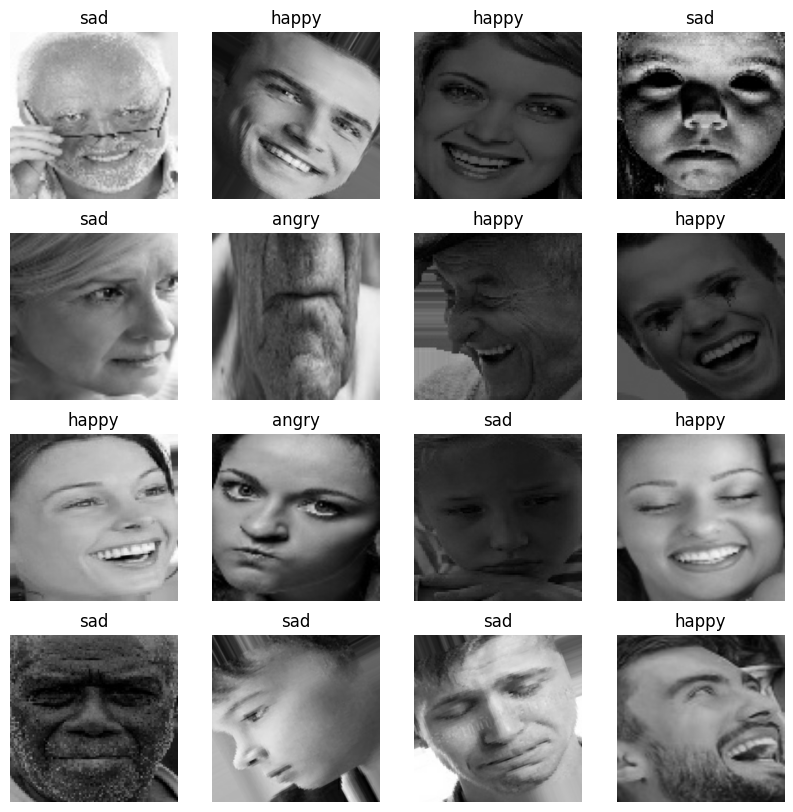

In [ ]:
plt.figure(figsize=[10, 10])

for images, labels in train_dataset.take(1):
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255.0)
        plt.axis("off")
        plt.title(CLASS_NAMES[tf.math.argmax(labels[i])])

In [4]:
resize_rescale_layer = tf.keras.Sequential(
    [Resizing(*CONFIG["im_size"]), Rescaling(1.0 / 255.0)]
)

lenet_model = tf.keras.Sequential(
    [
        Input(shape=(CONFIG["input_shape"])),
        resize_rescale_layer,
        Conv2D(
            filters=CONFIG["filters_1"],
            kernel_size=CONFIG["kernel_size"],
            strides=CONFIG["strides_1"],
            padding="valid",
            activation=CONFIG["activation_1"],
            kernel_regularizer=L2(CONFIG["regularization_l2"]),
        ),
        BatchNormalization(),
        MaxPool2D(pool_size=CONFIG["pool_size"], strides=CONFIG["strides_2"]),
        Dropout(rate=CONFIG["dropout"]),
        Conv2D(
            filters=CONFIG["filters_2"],
            kernel_size=CONFIG["kernel_size"],
            strides=CONFIG["strides_1"],
            padding="valid",
            activation=CONFIG["activation_1"],
            kernel_regularizer=L2(CONFIG["regularization_l2"]),
        ),
        BatchNormalization(),
        MaxPool2D(pool_size=CONFIG["pool_size"], strides=CONFIG["strides_2"]),
        Flatten(),
        Dense(
            CONFIG["dense_1"],
            activation=CONFIG["activation_1"],
            kernel_regularizer=L2(CONFIG["regularization_l2"]),
        ),
        BatchNormalization(),
        Dropout(rate=CONFIG["dropout"]),
        Dense(
            CONFIG["dense_2"],
            activation=CONFIG["activation_1"],
            kernel_regularizer=L2(CONFIG["regularization_l2"]),
        ),
        BatchNormalization(),
        Dense(CONFIG["dense_out"], activation=CONFIG["activation_2"]),
    ]
)

lenet_model.compile(
    optimizer=Adam(learning_rate=CONFIG["learning_rate"]),
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=2)],
)

lenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     6,150,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,153,119 (23.47 MB)

 Trainable params: 6,152,855 (23.47 MB)

 Non-trainable params: 264 (1.03 KB)

In [5]:
history = lenet_model.fit(
    train_dataset, validation_data=test_dataset, epochs=CONFIG["epochs"], verbose=1
)

Epoch 1/2


I0000 00:00:1730668546.732310   24796 service.cc:148] XLA service 0x7f56840065f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730668546.732429   24796 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-11-03 18:15:47.147435: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730668547.891854   24796 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-03 18:15:51.607691: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,6,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[6,3,3,3]{3,2,1,0}, f32[6]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_

211/213 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - categorical_accuracy: 0.4176 - loss: 30.7307 - top_k_categorical_accuracy: 0.7396

2024-11-03 18:16:37.540529: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[15,6,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,3,256,256]{3,2,1,0}, f32[6,3,3,3]{3,2,1,0}, f32[6]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-03 18:16:38.003096: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[15,16,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,6,127,127]{3,2,1,0}, f32[16,6,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - categorical_accuracy: 0.4178 - loss: 30.5776 - top_k_categorical_accuracy: 0.7397

2024-11-03 18:16:48.303454: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554944 bytes after encountering the first element of size 33554944 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-11-03 18:16:50.843998: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,6,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[6,3,3,3]{3,2,1,0}, f32[6]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-03 18:16:51.481916: I external/local_xla/xla/servic

213/213 ━━━━━━━━━━━━━━━━━━━━ 77s 255ms/step - categorical_accuracy: 0.4179 - loss: 30.5020 - top_k_categorical_accuracy: 0.7398 - val_categorical_accuracy: 0.4416 - val_loss: 3.9643 - val_top_k_categorical_accuracy: 0.7739
Epoch 2/2


2024-11-03 18:16:59.144972: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554944 bytes after encountering the first element of size 33554944 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - categorical_accuracy: 0.4532 - loss: 2.3897 - top_k_categorical_accuracy: 0.7747

2024-11-03 18:17:29.658927: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554944 bytes after encountering the first element of size 33554944 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


213/213 ━━━━━━━━━━━━━━━━━━━━ 34s 159ms/step - categorical_accuracy: 0.4532 - loss: 2.3898 - top_k_categorical_accuracy: 0.7747 - val_categorical_accuracy: 0.4416 - val_loss: 3.5443 - val_top_k_categorical_accuracy: 0.7739


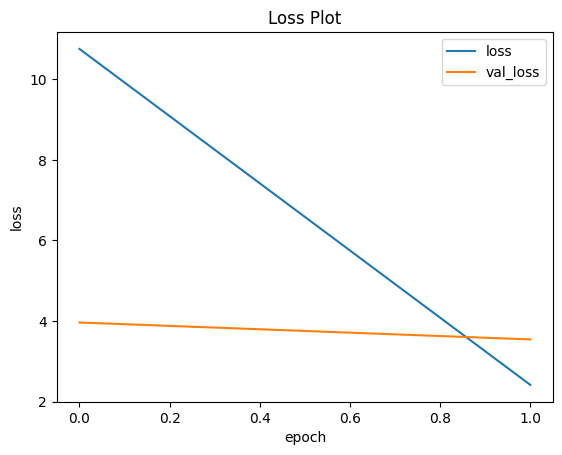

In [6]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title("Loss Plot")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

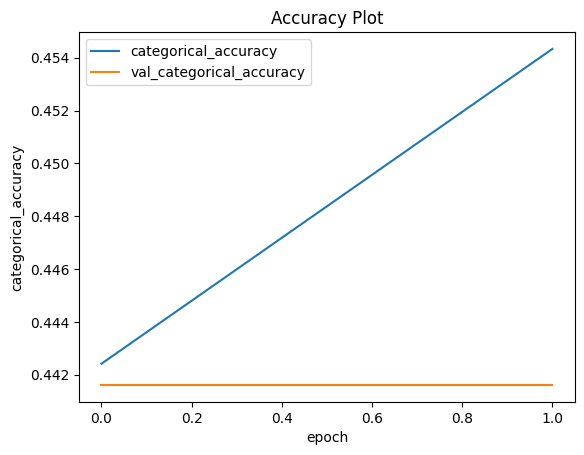

In [7]:
plt.figure()
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.legend(["categorical_accuracy", "val_categorical_accuracy"])
plt.title("Accuracy Plot")
plt.xlabel("epoch")
plt.ylabel("categorical_accuracy")
plt.show()